In [1]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# `KuramotoPINN` class
## Key Components
1. Initialization (`__init__` method):
   - `num_oscillators`: Number of oscillators in the system (default is 3)
   - `self.net`: A feedforward neural network with the following architecture
     - Input layer: 2 neurons (time `t` and oscillator indes `idx`)
     - Hidden layers: Three layers with 32, 64, and 32 neurons, each followed by a Tanh activation function
     - Output layer: 1 neruon (predicted phase of the oscillator)
   - `self.natural_frequencies`: A learnable parameter representing the natural frequencies of the oscillators, initialized randomly
   - `self.K`: A learnable parameter representing the coupling strength between oscillators, initialized to 1.0
2. Forward Pass (`forward` method):
   - Takes time `t` and oscillator index `idx` as inputs
   - Concatenates `t` and `idx` into a single tensor and passes it through a neural network (`self.net`) to predict the phase of the oscillator
3. Physics Loss (`physics_loss` method):
   - Computes the loss based on teh Kuramoto model's governing equations
   - Steps:
     - **Phase predictions:** Uses the forward method to predict the phases of the oscillators
     - **Time derivatives:** Computes the time derivative of the predicted phases using `torch.autograd.grad`
     - **Coupling term:** Calculates the coupling term for reach oscillator by summing the sine of phase differences with other oscillators
     - **Physics equation:** Implements the Kuramoto equation:
            $$\dot{\theta}_i(t) = \omega_i + \frac{K}{N}\sum_{j=1}^{N}{\sin{(\theta_j-\theta_i)}}$$
     - **Loss calculation:** Computes the mean squared error between the left and right sides of the quation

In [2]:
class KuramotoPINN(nn.Module):
    def __init__(self, num_oscillators=3):
        super(KuramotoPINN, self).__init__()
        self.num_oscillators = num_oscillators
        
        # Neural network architecture
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        
        # Natural frequencies of oscillators
        self.natural_frequencies = nn.Parameter(
            torch.randn(num_oscillators)
        )
        
        # Coupling strength
        self.K = nn.Parameter(torch.tensor([1.0]))

    def forward(self, t, idx):
        # Create input tensor
        x = torch.cat([t, idx], dim=1)
        return self.net(x)

    def physics_loss(self, t, idx):
        t = t.detach().requires_grad_(True)
        
        # Compute phase predictions
        phases = self.forward(t, idx)  # Shape: [batch_size, 1]
        
        # Compute time derivatives
        dt = torch.autograd.grad(
            phases, t,
            grad_outputs=torch.ones_like(phases),
            create_graph=True
        )[0]  # Shape: [batch_size, 1]
        
        # Kuramoto model physics
        coupling_term = torch.zeros_like(phases)  # Shape: [batch_size, 1]
        for j in range(self.num_oscillators):
            j_idx = torch.full_like(idx, j, dtype=torch.float32)
            phase_j = self.forward(t, j_idx)
            coupling_term += torch.sin(phase_j - phases)
        
        # Get natural frequencies for each oscillator index
        idx_squeezed = idx.long().squeeze()
        natural_freq = self.natural_frequencies[idx_squeezed].unsqueeze(1)  # Shape: [batch_size, 1]
        
        # Physical equation
        physics_eq = dt - (natural_freq + self.K * coupling_term / self.num_oscillators)
        
        return torch.mean(physics_eq ** 2)

In [3]:
def generate_training_data(num_points=1000, num_oscillators=3):
    t = torch.linspace(0, 10, num_points).unsqueeze(1)
    idx = torch.randint(0, num_oscillators, (num_points, 1)).float()
    return t, idx

# Training setup
model = KuramotoPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
num_epochs = 1000

# Training loop
losses = []
for epoch in range(num_epochs):
    try:
        t, idx = generate_training_data()
        
        loss = model.physics_loss(t, idx)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
    except Exception as e:
        print(f"Error in epoch {epoch+1}: {str(e)}")
        continue

Epoch [100/1000], Loss: 0.0555
Epoch [200/1000], Loss: 0.0190
Epoch [300/1000], Loss: 0.0065
Epoch [400/1000], Loss: 0.0021
Epoch [500/1000], Loss: 0.0007
Epoch [600/1000], Loss: 0.0003
Epoch [700/1000], Loss: 0.0003
Epoch [800/1000], Loss: 0.0003
Epoch [900/1000], Loss: 0.0003
Epoch [1000/1000], Loss: 0.0003


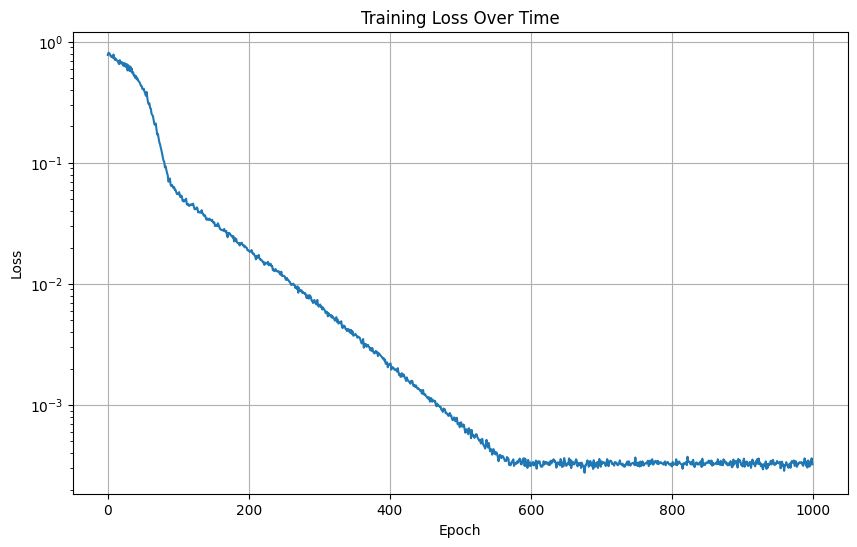

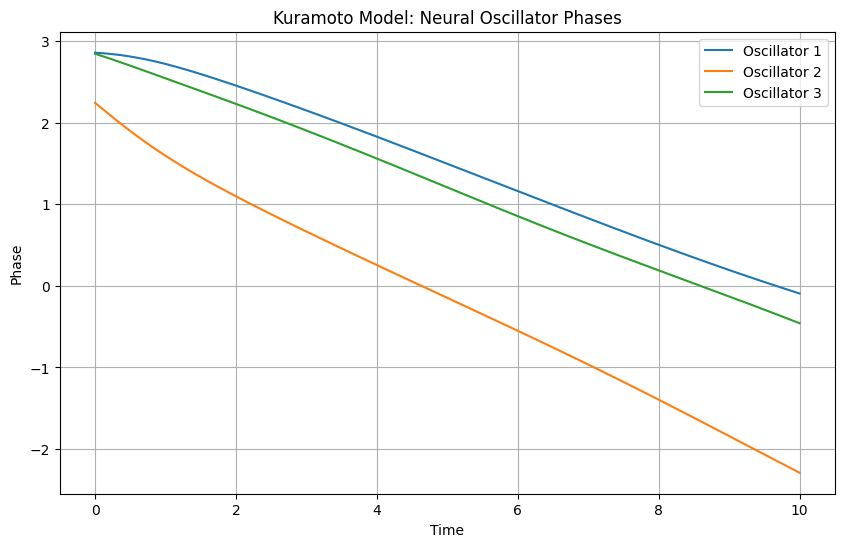

In [4]:
# Visualization
def plot_training_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

def plot_results(model, num_oscillators=3):
    with torch.no_grad():
        t = torch.linspace(0, 10, 1000).unsqueeze(1)
        plt.figure(figsize=(10, 6))
        
        for i in range(num_oscillators):
            idx = torch.full_like(t, i, dtype=torch.float32)
            phases = model(t, idx).detach().numpy()
            plt.plot(t.numpy(), phases, label=f'Oscillator {i+1}')
        
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Kuramoto Model: Neural Oscillator Phases')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot results after training
plot_training_loss(losses)
plot_results(model)